In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output # For cleaner output during optimization

# Device configuration (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Using device: {device}")

Using device: cuda


In [2]:
# Model Definition and Training (Quick MNIST)

# Define the simple CNN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2)) # Layer to interpret (conv1)
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2)) # Layer to interpret (conv2)
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

# MNIST Data Loaders
# We only need the training loader to train the model quickly
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True, transform=transforms.Compose([
            transforms.ToTensor(),
            ])),
    batch_size=64, shuffle=True)

# Initialize the model
model = Net().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.01) # Use Adam for faster convergence
epochs = 3 # A few epochs is enough for demonstration

# Function to train the model
def train(model, device, train_loader, optimizer, epoch):
    model.train() # Set model to training mode
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')

print("Starting quick model training for interpretability demo...")
for epoch in range(1, epochs + 1):
    train(model, device, train_loader, optimizer, epoch)

# Crucial: Set the model to evaluation mode after training, and freeze its parameters
# We don't want the model's weights to change during visualization
model.eval()
for param in model.parameters():
    param.requires_grad = False

print("\nModel training complete and frozen for interpretation.")

100%|██████████| 9.91M/9.91M [00:00<00:00, 17.9MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 479kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.44MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 11.9MB/s]


Starting quick model training for interpretability demo...
Train Epoch: 1 [0/60000 (0%)]	Loss: 2.301575
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.888748
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.422770
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.410639
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.211572
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.156962
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.225517
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.228848
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.399617
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.870866
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.391358
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.165578
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.249694
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.711615
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.413608
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.192085
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.211915
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.227712
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.536449
Tra

In [9]:
# Feature Visualization Core Logic (FINAL CORRECTED VERSION)

# --- Configuration for Visualization (keeping same target) ---
target_layer = model.conv1
target_channel = 5
target_neuron_xy = (2, 2)

# --- Hook Setup (same as final successful version) ---
activations_store = []
def hook_fn(module, input, output):
    activations_store.clear()
    activations_store.append(output)
hook = target_layer.register_forward_hook(hook_fn)

# --- Input Image Initialization (CRITICAL FIX 1: Start from Gray) ---
# Start with a uniform gray image (0.5 value) for cleaner feature generation
input_img = torch.full((1, 1, 28, 28), 0.5, requires_grad=True, device=device)

# --- Optimization Parameters (CRITICAL FIX 2: Reduce Learning Rate) ---
# Reduce learning rate significantly to avoid overshooting and getting stuck
viz_optimizer = optim.Adam([input_img], lr=0.005)
num_iterations = 400 # Increase iterations for finer detail
# ---

print(f"Visualizing neuron in {target_layer.__class__.__name__}, channel {target_channel}, location {target_neuron_xy}...")

# --- Optimization Loop ---
for i in range(num_iterations):
    viz_optimizer.zero_grad()
    model(input_img)

    # Access the captured activation tensor
    activations = activations_store[0]
    neuron_activation = activations[0, target_channel, target_neuron_xy[0], target_neuron_xy[1]]

    # Maximize the activation
    (-neuron_activation).backward()

    # Update the input image
    viz_optimizer.step()

    # --- Post-processing ---
    # Clip pixel values to a valid range (0-1 for images)
    input_img.data.clamp_(0, 1)

    if (i+1) % 50 == 0:
        print(f"Iteration {i+1}/{num_iterations}, Activation: {neuron_activation.item():.4f}")

hook.remove()
print("\nFeature visualization optimization complete.")

Visualizing neuron in Conv2d, channel 5, location (2, 2)...
Iteration 50/400, Activation: 0.0145
Iteration 100/400, Activation: 1.5175
Iteration 150/400, Activation: 1.5476
Iteration 200/400, Activation: 1.5476
Iteration 250/400, Activation: 1.5476
Iteration 300/400, Activation: 1.5476
Iteration 350/400, Activation: 1.5476
Iteration 400/400, Activation: 1.5476

Feature visualization optimization complete.


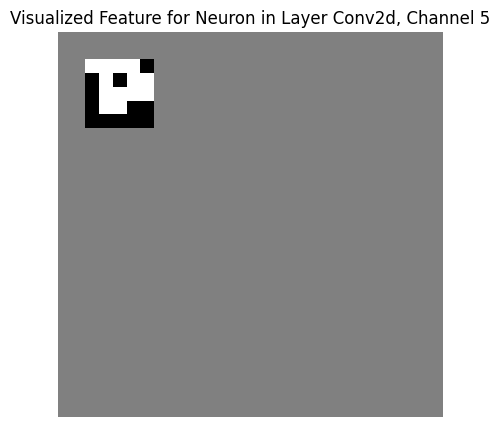

Successfully generated and visualized the feature.


In [10]:
# Visualize the Feature

# Move the optimized image to CPU and convert to numpy for plotting
visualized_feature = input_img.squeeze().detach().cpu().numpy()

plt.figure(figsize=(5, 5))
plt.imshow(visualized_feature, cmap='gray')
plt.title(f"Visualized Feature for Neuron in Layer {target_layer.__class__.__name__}, Channel {target_channel}")
plt.axis('off') # Hide axes for cleaner image
plt.show()

print("Successfully generated and visualized the feature.")